# NOTEBOOK 3c: MODELING - LassoCV

Since the ElasticNet l1_ratio stongly favored Lasso regression we will implement the LassoCV algorithm to try and fine-tune our predictions. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import re
import time

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel, f_regression, RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(42)

%matplotlib inline

Loading the clean training data from Notebook 02

In [2]:
df = pd.read_csv('../data/train_clean.csv', index_col='Id', na_filter=False)

In [3]:
df.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Unf SF,Total Bsmt SF,Central Air,...,Misc Feature_none,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
Id,,,,,,,,,,,,,,,,,,,,,
109,0.0,13517,6,8,1976,2005,289.0,192.0,725.0,1,...,1,0,0,0,0,0,0,0,0,1
544,43.0,11492,7,5,1996,1997,132.0,276.0,913.0,1,...,1,0,0,0,0,0,0,0,0,1
153,68.0,7922,5,7,1953,2007,0.0,326.0,1057.0,1,...,1,0,0,0,0,0,0,0,0,1
318,73.0,9802,5,5,2006,2007,0.0,384.0,384.0,1,...,1,0,0,0,0,0,0,0,0,1
255,82.0,14235,6,8,1900,1993,0.0,676.0,676.0,1,...,1,0,0,0,0,0,0,0,0,1


In [4]:
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
model = 'lasso'

In [6]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold(0)),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k=37)),
#    ('enet', ElasticNetCV()),
    ('lasso', LassoCV()),
#     ('ridge', RidgeCV()),
#     ('knn', KNeighborsRegressor),
])


In [7]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a22f62620>)), ('lasso', LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [8]:
pipe.score(X_train,y_train)

0.8393892080135616

In [9]:
pipe.score(X_test,y_test)

0.883067189406049

The unfit Lasso model performs much better than the ElasticNet unfit pipe score.

In [10]:
params = {
    'var_thresh__threshold': [0,.001,.01,.02,.05],
    'kbest__k': [5,7,13,17,23,37,53,79,'all'],
    'lasso__n_alphas': [1000],
}

We will search over 1000 alphas to optimize our mode fit.

In [11]:
gs = GridSearchCV(pipe, params, cv=5, scoring='r2', verbose=1)

In [12]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=37, score_func=<function f_regression at 0x1a22f62620>)), ('lasso', LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_thresh__threshold': [0, 0.001, 0.01, 0.02, 0.05], 'kbest__k': [5, 7, 13, 17, 23, 37, 53, 79, 'all'], 'lasso__n_alphas': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [13]:
gs.best_params_

{'kbest__k': 'all', 'lasso__n_alphas': 1000, 'var_thresh__threshold': 0}

In [14]:
gs.best_estimator_.named_steps['lasso'].alpha_

1019.9537141596129

In [15]:
columns = X.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

X_weights = pd.DataFrame(gs.best_estimator_.named_steps[f'{model}'].coef_, 
             index = columns, 
             columns=['weight'])
X_weights['abs_weight'] = X_weights['weight'].abs()

In [16]:
X_weights.sort_values(['abs_weight'],ascending=False)

,weight,abs_weight
Gr Liv Area,21734.381695,21734.381695
Roof Matl_ClyTile,-14337.323352,14337.323352
Overall Qual,12668.845549,12668.845549
Misc Feature_Elev,-11878.158808,11878.158808
BsmtFin SF,7608.951044,7608.951044
Kitchen Qual_Ex,7281.556933,7281.556933
Year Built,6874.679671,6874.679671
Total Bsmt SF,6384.445430,6384.445430
Garage Area,5755.149271,5755.149271
Bldg Type_1Fam,5301.715616,5301.715616


In [17]:
def md_coef_table(labels, weights):
    print('| feature | weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')

In [18]:
weights = X_weights.sort_values('weight', ascending=False)['weight']
labels = weights.index

In [19]:
md_coef_table(labels, weights);

| feature | weight |
| --- | --- |
| Gr Liv Area | 2.17e+04 |
| Overall Qual | 1.27e+04 |
| BsmtFin SF | 7.61e+03 |
| Kitchen Qual_Ex | 7.28e+03 |
| Year Built | 6.87e+03 |
| Total Bsmt SF | 6.38e+03 |
| Garage Area | 5.76e+03 |
| Bldg Type_1Fam | 5.30e+03 |
| Bsmt Qual_Ex | 5.21e+03 |
| Exter Qual_Ex | 4.80e+03 |
| Neighborhood_NridgHt | 4.58e+03 |
| Lot Area | 4.54e+03 |
| Neighborhood_StoneBr | 4.30e+03 |
| Overall Cond | 4.25e+03 |
| Bsmt Exposure_Gd | 4.07e+03 |
| Sale Type_New | 3.85e+03 |
| Neighborhood_NoRidge | 3.65e+03 |
| Mas Vnr Area | 3.15e+03 |
| Functional_Typ | 2.52e+03 |
| Foundation_PConc | 2.39e+03 |
| Fireplaces | 2.34e+03 |
| Exterior_Brk | 2.08e+03 |
| Year Remod/Add | 2.04e+03 |
| Neighborhood_Crawfor | 1.84e+03 |
| Roof Matl_WdShngl | 1.56e+03 |
| Neighborhood_Somerst | 1.31e+03 |
| Neighborhood_GrnHill | 1.29e+03 |
| Baths | 1.25e+03 |
| 1st Flr SF | 1.21e+03 |
| Exterior_Cmnt | 9.88e+02 |
| Bsmt Fin_GLQ | 9.78e+02 |
| Wood Deck SF | 7.05e+02 |
| Garage Qual_Gd

In [20]:
beta0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
beta0

180368.8058631922

In [21]:
gs.score(X_train,y_train)

0.9230697894347617

In [22]:
gs.score(X_test,y_test)

0.9274910729747848

The train/test scores align well and suggest we have a well fit model.

In [23]:
preds = gs.predict(X_test)

In [24]:
r2_score(preds, y_test)

0.9200296538259437

In [25]:
(mean_squared_error(preds, y_test))**.5

22346.41083295515

The r2 and rmse also suggest a much better model for our data than lr or ElasticNet. It would be interesting to see if further tuning of the model can improve our predictions.

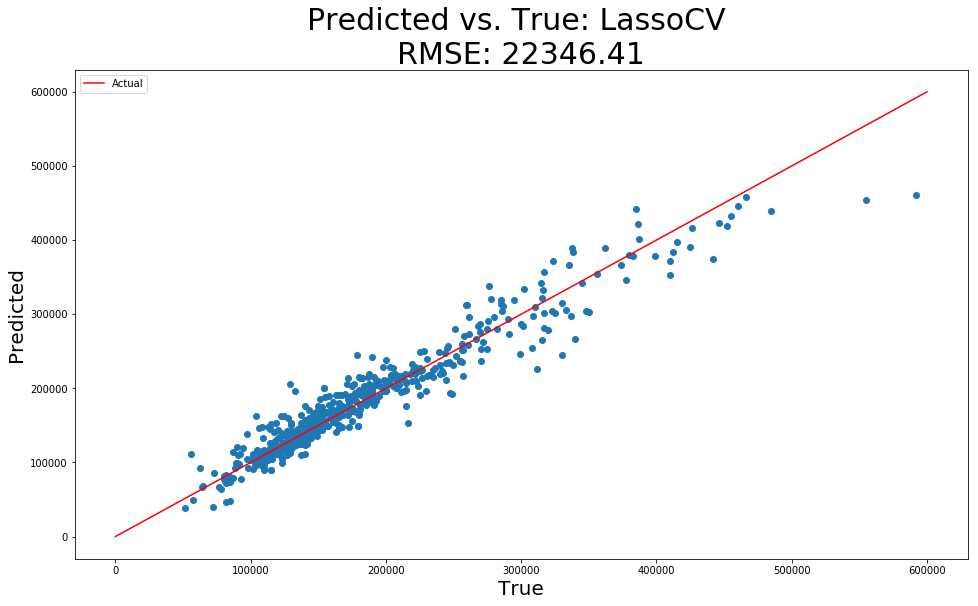

In [26]:
plt.figure(figsize=(16,9))
plt.title(f'Predicted vs. True: LassoCV \nRMSE: {mean_squared_error(y_test, gs.predict(X_test))**.5:.2f}', fontsize=30);

plt.scatter(y_test, gs.predict(X_test))
plt.plot([0, 600000], [0, 600000], color='r')

plt.ylabel('Predicted', fontsize=20)
plt.xlabel('True', fontsize=20)
plt.legend(['Actual'])
 
    
#plt.savefig('../images/lasso1000.png', dpi=300)

This model performs better than our previous models across all values. Most importantly, it more closely predicts the values of the outliers at \$550000-600000.

## Plotting Beta Weights

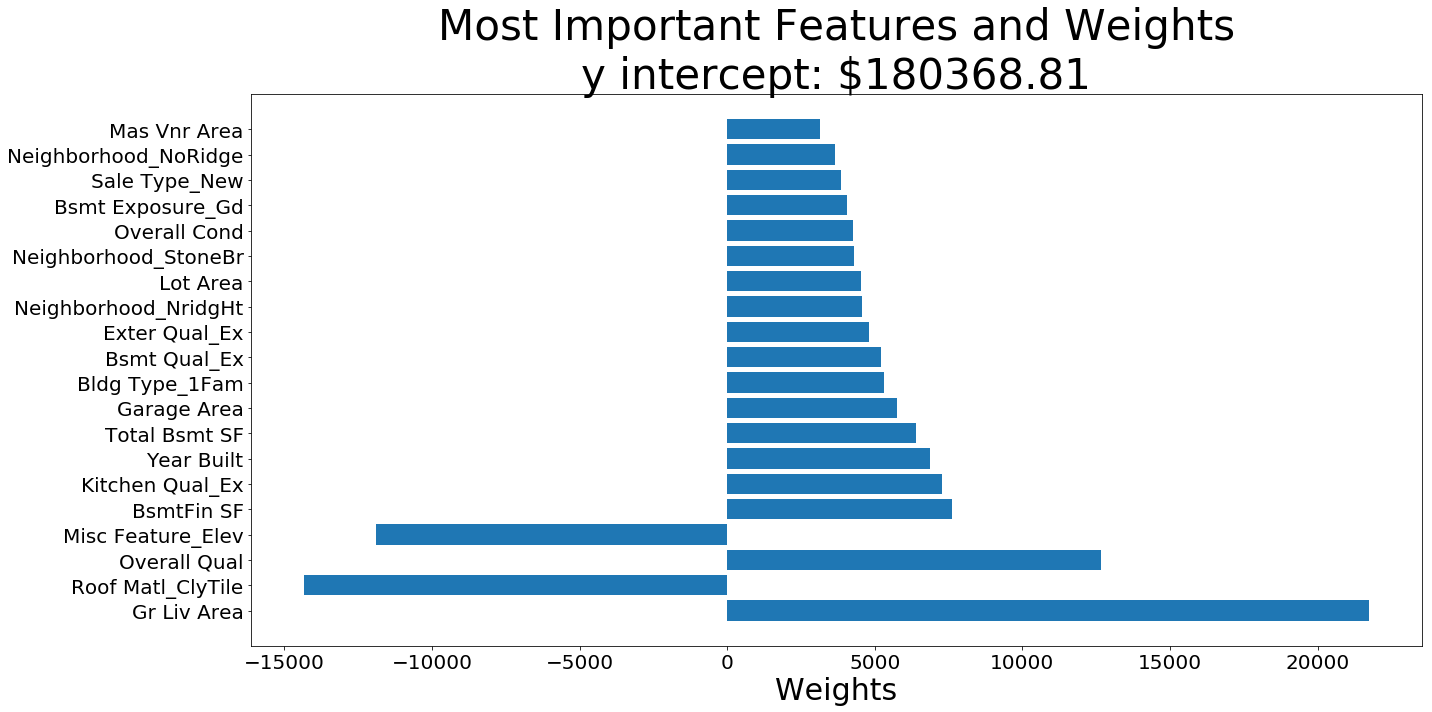

In [27]:
weights = X_weights.sort_values('abs_weight', ascending=False)['weight'].head(20)
beta_0 = gs.best_estimator_.named_steps[f'{model}'].intercept_
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

plt.savefig('../images/lasso1000feat.png', dpi=300)

In [28]:
X_test.shape

(512, 254)

# Saving out column names and scaled data for use in future models.

Function to save out files with a clear description of each run. Source: Douglas Strodman.

In [29]:
def filename_format_log(file_path, 
                        logfile='../assets/file_log.txt', 
                        now=round(time.time()), 
                        file_description=None): 
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}'
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

Saving columns that were retained by the model

In [30]:
columns = X_train.columns

In [31]:
formatted_name, now, file_description= filename_format_log('../assets/columns.pkl')

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

Please provide a brief description:  re-run for data dictionary


In [33]:
formatted_name, _, _= filename_format_log('../assets/gs.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(gs, f)

# Continue to NOTEBOOK 03e: MODELING - KNearestNeighbors